<a href="https://colab.research.google.com/github/AgainstEntropy/ECE-GY-7123-DL-Assignments/blob/main/notebooks/visual_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Transformers in Computer Vision



Transformer architectures owe their origins in natural language processing (NLP), and indeed form the core of the current state of the art models for most NLP applications.

We will now see how to develop transformers for processing image data (and in fact, this line of deep learning research has been gaining a lot of attention in 2021). The *Vision Transformer* (ViT) introduced in [this paper](https://arxiv.org/pdf/2010.11929.pdf) shows how standard transformer architectures can perform very well on image. The high level idea is to extract patches from images, treat them as tokens, and pass them through a sequence of transformer blocks before throwing on a couple of dense classification layers at the very end.


Some caveats to keep in mind:
- ViT models are very cumbersome to train (since they involve a ton of parameters) so budget accordingly.
- ViT models are a bit hard to interpret (even more so than regular convnets).
- Finally, while in this notebook we will train a transformer from scratch, ViT models in practice are almost always *pre-trained* on some large dataset (such as ImageNet) before being transferred onto specific training datasets.





# Setup

As usual, we start with basic data loading and preprocessing.

In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 810.1 kB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
from torch import nn, einsum
import torch.nn.functional as F
from torch import optim

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import numpy as np
import torchvision
from torchvision import transforms
import time

In [ ]:
torch.manual_seed(42)

DOWNLOAD_PATH = './FashionMNIST/'
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000

MEAN = 0.2859
STD = 0.3530

train_set = torchvision.datasets.FashionMNIST(DOWNLOAD_PATH, train=True, download=True,
                                              transform=transforms.Compose([
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(MEAN, STD)
                                                  ])
                                              )
test_set = torchvision.datasets.FashionMNIST(DOWNLOAD_PATH,train=False,download=True,
                                             transform=transforms.Compose([
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(MEAN, STD)
                                                  ])
                                              )

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

using device: cuda


# The ViT Model



We will now set up the ViT model. There will be 3 parts to this model:

* A ``patch embedding'' layer that takes an image and tokenizes it. There is some amount of tensor algebra involved here (since we have to slice and dice the input appropriately), and the `einops` package is helpful. We will also add learnable positional encodings as parameters.
* A sequence of transformer blocks. This will be a smaller scale replica of the original proposed ViT, except that we will only use 4 blocks in our model (instead of 32 in the actual ViT).
* A (dense) classification layer at the end.

Further, each transformer block consists of the following components:

* A *self-attention* layer with $H$ heads,
* A one-hidden-layer (dense) network to collapse the various heads. For the hidden neurons, the original ViT used something called a [GeLU](https://arxiv.org/pdf/1606.08415.pdf) activation function, which is a smooth approximation to the ReLU. For our example, regular ReLUs seem to be working just fine. The original ViT also used Dropout but we won't need it here.
* *layer normalization* preceeding each of the above operations.

Some care needs to be taken in making sure the various dimensions of the tensors are matched.

In [ ]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(), #nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [ ]:
model = ViT(image_size=28, patch_size=4, num_classes=10, channels=1, dim=64, depth=6, heads=4, mlp_dim=128)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

Let's see how the model looks like.

In [ ]:
model

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
    (1): Linear(in_features=16, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=64, out_features=768, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=256, out_features=64, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=64, out_features=128, bias=True)
              (1): ReLU()
              (2): Dr

This is it -- 4 transformer blocks, followed by a linear classification layer. Let us quickly see how many trainable parameters are present in this model.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

499722


About half a million. Not too bad; the bigger NLP type models have several tens of millions of parameters. But since we are training on MNIST this should be more than sufficient.

# Training and testing

All done! We can now train the ViT model. The following again is boilerplate code.


In [ ]:
def train_epoch(model, optimizer, data_loader):
    total_samples = len(data_loader.dataset)
    model.train()

    correct_samples = 0
    total_loss = 0

    for i, (data, target) in enumerate(data_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        _, pred = torch.max(output, dim=1)
        total_loss += loss.item()
        correct_samples += pred.eq(target).sum().item()

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))

    avg_loss = total_loss / total_samples
    avg_acc = correct_samples / total_samples

    print('\nAverage Train loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * avg_acc) + '%)\n')

    return avg_loss, avg_acc

In [ ]:
def evaluate(model, data_loader):
    model.eval()

    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += loss.item()
            correct_samples += pred.eq(target).sum().item()

    avg_loss = total_loss / total_samples
    avg_acc = correct_samples / total_samples

    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * avg_acc) + '%)\n')

    return avg_loss, avg_acc


The following will take a bit of time (on CPU).  Each epoch should take about 2 to 3 minutes. At the end of training, we should see upwards of 95% test accuracy.

In [ ]:
train_loss_history, test_loss_history = [], []
train_accuracy_history, test_accuracy_history = [], []

In [ ]:
N_EPOCHS = 10

start_time = time.time()

for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)

    train_loss, train_acc = train_epoch(model, optimizer, train_loader)
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_acc)

    test_loss, test_acc = evaluate(model, test_loader)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_acc)

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Epoch: 1
[    0/60000 (  0%)]  Loss: 0.2103
[10000/60000 ( 17%)]  Loss: 0.2356
[20000/60000 ( 33%)]  Loss: 0.2608
[30000/60000 ( 50%)]  Loss: 0.3043
[40000/60000 ( 67%)]  Loss: 0.1318
[50000/60000 ( 83%)]  Loss: 0.2040

Average Train loss: 0.0023  Accuracy:54780/60000 (91.30%)


Average test loss: 0.3505  Accuracy: 8783/10000 (87.83%)

Epoch: 2
[    0/60000 (  0%)]  Loss: 0.2873
[10000/60000 ( 17%)]  Loss: 0.1793
[20000/60000 ( 33%)]  Loss: 0.1506
[30000/60000 ( 50%)]  Loss: 0.3065
[40000/60000 ( 67%)]  Loss: 0.1295
[50000/60000 ( 83%)]  Loss: 0.2192

Average Train loss: 0.0022  Accuracy:55021/60000 (91.70%)


Average test loss: 0.3234  Accuracy: 8834/10000 (88.34%)

Epoch: 3
[    0/60000 (  0%)]  Loss: 0.1695
[10000/60000 ( 17%)]  Loss: 0.2771
[20000/60000 ( 33%)]  Loss: 0.2481
[30000/60000 ( 50%)]  Loss: 0.2434
[40000/60000 ( 67%)]  Loss: 0.1896
[50000/60000 ( 83%)]  Loss: 0.1890

Average Train loss: 0.0021  Accuracy:55089/60000 (91.81%)


Average test loss: 0.3250  Accuracy: 8840/10

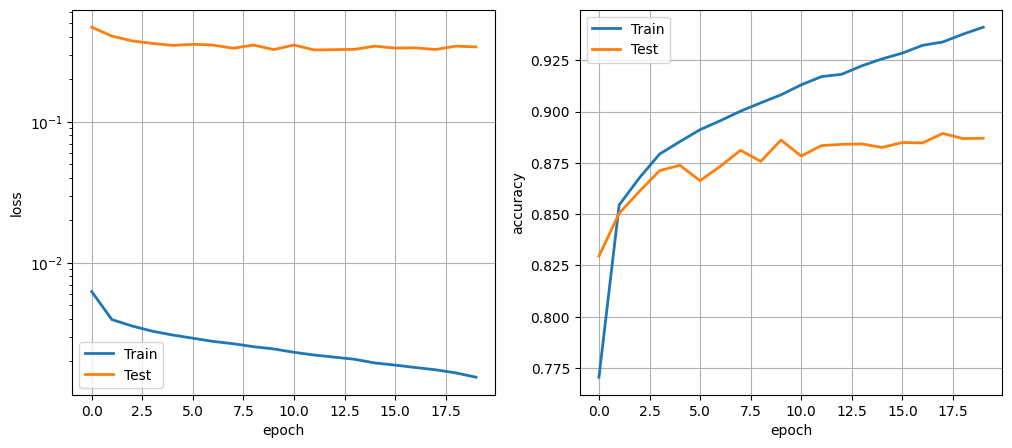

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(train_loss_history, '-', linewidth=2, label='Train')
axes[0].plot(test_loss_history, '-', linewidth=2, label='Test')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].grid(True)
axes[0].legend()
axes[0].set_yscale('log')

def maybe_transform(history):
    new = []
    for item in history:
        if isinstance(item, torch.Tensor):
            new.append(item.item())
        else:
            new.append(item)
    return new

axes[1].plot(maybe_transform(train_accuracy_history), '-', linewidth=2, label='Train')
axes[1].plot(maybe_transform(test_accuracy_history), '-', linewidth=2, label='Test')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
axes[1].grid(True)
axes[1].legend()

plt.show()

In [ ]:
import random

test_images = []
test_labels = []
random_indexes = [random.randrange(len(test_set)) for _ in range(3)]

for idx in random_indexes:
    image, label = test_set[idx]
    test_images.append(image)
    test_labels.append(label)
print(random_indexes)
print(test_labels)

[8716, 540, 6542]
[3, 4, 0]


In [ ]:
model.eval()

test_images_inp = torch.stack(test_images, 0).cuda()
logits = model(test_images_inp).cpu().detach()
probs = logits.softmax(dim=-1)
preds = probs.max(-1)[1]

print('Predicted:', preds.numpy())

Predicted: [3 4 6]


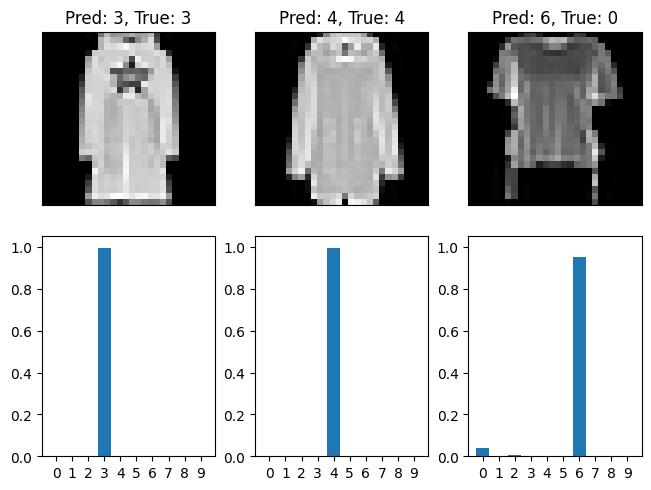

In [ ]:
fig, axes = plt.subplots(2, 3, layout='constrained')

for i in range(3):
    axes[0, i].imshow(test_images[i].squeeze().cpu(), cmap=plt.cm.gray)
    axes[0, i].set_title(f'Pred: {preds[i]}, True: {test_labels[i]}')
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])

    axes[1, i].bar(range(10), probs[i])
    axes[1, i].set_xticks(range(10))
    axes[1, i].set_ylim(0, 1.05)